# Latent Dirichlet Allocation (LDA) for book topic creation

Emil Javurek
13331124



I will take my scraped data about books and feed their descriptions into an LDA model to find general "topic" groups of books. Finally, I plan to compare this with the genres of the books that goodreads records.

### Step 1 - Setup

In [1]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import ast

C:\Users\HP\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\HP\anaconda3\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
#read data
books = pd.read_csv('to_read_books_scraped.csv')

In [26]:
display(books.head(5))
#delete rows with missing values
books = books.dropna().reset_index(drop=True)
display(books.info())

#make genres column containt list of genres not string
books["genres"] = books["genres"].map(lambda x: ast.literal_eval(x))

,link,name,author,description,rating,number_of_ratings,number_of_reviews,genres,tokens,topic
0,https://www.goodreads.com//book/show/2657.To_K...,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,4.27,5496564,107012,"['Classics', 'Fiction', 'Historical', 'Histori...","[unforgettable, childhood, sleepy, southern, t...",0
1,https://www.goodreads.com//book/show/61439040-...,1984,George Orwell,The new novel by George Orwell is the major wo...,4.19,4022078,95604,"['Classics', 'Fiction', 'Science Fiction', 'Sc...","[george, orwell, major, work, previous, writin...",0
2,https://www.goodreads.com//book/show/1885.Prid...,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, has rem...",4.28,3790329,94287,"['Classics', 'Fiction', 'Romance', 'Historical...","[immediate, success, remain, popular, novel, e...",0
3,https://www.goodreads.com//book/show/19063.The...,The Book Thief,Markus Zusak,It is 1939. Nazi Germany. The country is holdi...,4.39,2276991,131841,"['Historical', 'Historical Fiction', 'Fiction'...","[nazi, germany, country, hold, breath, death, ...",2
4,https://www.goodreads.com//book/show/11870085-...,The Fault in Our Stars,John Green,Despite the tumor-shrinking medical miracle th...,4.16,4569603,169957,"['Young Adult', 'Romance', 'Fiction', 'Contemp...","[despite, tumor, shrink, medical, miracle, buy...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175 entries, 0 to 1174
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   link               1175 non-null   object 
 1   name               1175 non-null   object 
 2   author             1175 non-null   object 
 3   description        1175 non-null   object 
 4   rating             1175 non-null   float64
 5   number_of_ratings  1175 non-null   int64  
 6   number_of_reviews  1175 non-null   int64  
 7   genres             1175 non-null   object 
 8   tokens             1175 non-null   object 
 9   topic              1175 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 91.9+ KB


None

#### We are left with 1175 books
I believe this is a reasonable amount of data to work with. Of course, the more data, the better the result but this should be enough.

### Step 2 - Preprocessing the data

We don't want to work with string, we want to work with tokens.
We use the en_core_web_md pretrained model to tokenize our book description text.
We keep only a certain type of token.
Finally, we put tokens into a Gensim Dictionary (token, unique id, frequency counter) and into corpus (only id and frequency), which will be plugged into the model

In [4]:
#spaCy (pretrained) model

nlp = en_core_web_md.load()

In [5]:
#remove Tags I don't want
remove_tags= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

#add undesired words to stop words
nlp.Defaults.stop_words |= {"book","author","life","novel","reader","edition","writer","write","new","world","story","year"}

#tokenize descriptions
tokens = []

#run it through the pretrained en_core_web_md model to create tokens from words
for description in nlp.pipe(books["description"]):
    tokenized_description = []
    #keep only desired tokens
    for token in description:
        #select correct Part-Of-Speech tags, skip tokens in stopwords and skip non-alphabetic
        if token.pos_ not in remove_tags and not token.is_stop and token.is_alpha:
            #append just lowercase lemma of token
            tokenized_description.append(token.lemma_.lower())
    tokens.append(tokenized_description)

books['tokens'] = tokens


In [6]:
display(books['tokens'])

0       [unforgettable, childhood, sleepy, southern, t...
1       [george, orwell, major, work, previous, writin...
2       [immediate, success, remain, popular, novel, e...
3       [nazi, germany, country, hold, breath, death, ...
4       [despite, tumor, shrink, medical, miracle, buy...
                              ...                        
1170    [hemingway, memory, unknown, live, paris, twen...
1171    [time, rose, stop, wrong, thing, mistake, haun...
1172    [graphic, debut, rise, star, nd, stevenson, ba...
1173    [sookie, stackhouse, small, time, cocktail, wa...
1174    [hazel, camille, bradford, know, lot, man, cha...
Name: tokens, Length: 1175, dtype: object

In [18]:
# Create dictionary - that is, Dictionary Object from Gensim
# Each token assigned unique id and a frequency of occurence kept (total and in how many documents)
dictionary = Dictionary(books['tokens'])


In [8]:
# Filter dictionary - at least in 5 books, at most in __% of books, keep ___ most frequent tokens 
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus - bag of words - vector of word ids and their frequencies 
corpus = [dictionary.doc2bow(doc) for doc in books['tokens']]

### Step 3 - Build the model

We need to figure out how many topics to create. We use the C_v algorithm to determine this.
We use the LdaMulticore model and employ 4 workers (CPU cores) to speed up the training. This way my computer manages it in a few minutes.

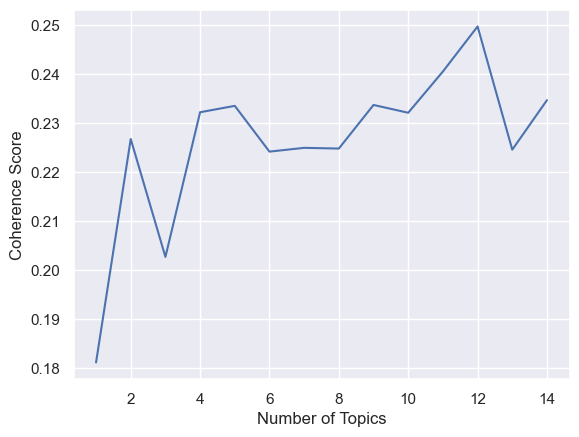

In [9]:
#see how many topics makes sense:

# Coherence score using C_v: - (0 to 1, higher = better)
topics = []
score = []
for i in range(1,15,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = books['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

We will go with 4 topics

In [10]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=4, workers = 4, passes=100)


### Step 4 - Visualization

Now that we have the topics, we need to visualize the results. We look at a few properties of the model and then we make 2 main visualizations: <br>
1) PCA (principle component analysis) <br>
2) Genres assignment to topics

In [11]:
# Print topics (as described by words)
lda_model.print_topics(-1)


[(0,
  '0.016*"people" + 0.015*"way" + 0.010*"time" + 0.010*"change" + 0.009*"woman" + 0.009*"work" + 0.008*"life" + 0.007*"human" + 0.007*"company" + 0.007*"business"'),
 (1,
  '0.012*"find" + 0.012*"power" + 0.011*"war" + 0.008*"love" + 0.008*"know" + 0.008*"secret" + 0.007*"fight" + 0.006*"magic" + 0.006*"heart" + 0.006*"king"'),
 (2,
  '0.014*"great" + 0.014*"work" + 0.011*"man" + 0.011*"classic" + 0.011*"history" + 0.010*"century" + 0.010*"american" + 0.009*"year" + 0.009*"reader" + 0.009*"character"'),
 (3,
  '0.017*"love" + 0.014*"family" + 0.013*"find" + 0.012*"old" + 0.011*"know" + 0.010*"secret" + 0.009*"day" + 0.009*"mother" + 0.009*"year" + 0.009*"friend"')]

In [20]:
# Where does a text belong to - example first book
print(books["name"][0])
print(lda_model[corpus][0])
print(books['description'][0])


To Kill a Mockingbird
[(0, 0.13558693), (1, 0.08625948), (2, 0.6966818), (3, 0.081471786)]
The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it. "To Kill A Mockingbird" became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic. Compassionate, dramatic, and deeply moving, "To Kill A Mockingbird" takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pathos. Now with over 18 million copies in print and translated into forty languages, this regional story by a young Alabama woman claims universal appeal. Harper Lee always considered her book to be a simple love story. Today it is regarded as a masterpiece of American literature.


In [13]:
# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

C:\Users\HP\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [21]:
# Save the report
pyLDAvis.save_html(lda_display, 'index.html')

In [15]:
#how many books belong to each topic?
books['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(books['description']))]
books.topic.value_counts()

0    695
1    319
2     97
3     64
Name: topic, dtype: int64

#### Let's find the genres of books belonging to a topic

In [27]:
#associate genres to topics


def genres_of_topics(model,corpus,num_of_topics):
    """
    Given an LDA model from the book descriptions
    returns a list of lists containing for each topic the genres that the model assigns most often to that topic
    """
    #step 1:
    #dictionary with genres as keys and values dictionaries with "summed" probabilities of belonging to topics 
    #(sum of probabilities of books that have this genre)
    output = {}
    #iterate over books
    for index, book in books["genres"].items():
        #iterate over genres of the book
        for genre in book:
            
            #create output structure if it doesnt exist           
            if not output.get(genre):
                output[genre] = {}
                for ii in range(num_of_topics):
                    output[genre][ii] = 0

            #add topic probabilities to genre obtained from the current book
            for topic in model[corpus][index]:
                output[genre][topic[0]] += topic[1]
    #step 2:
    #dictionary with genres as keys and values their best fitting topic and associated "summed probability" value
    genres = {}

    #lets do it the dumb way:
    for genre in output:
        dicti = output[genre]
        max_topic = max(dicti, key = dicti.get)
        genres[genre] = max_topic, dicti[max_topic]

    #step 3: list that is the "step 2" dictionary inversed
    inverse = [(value, key) for key, value in genres.items()]
    
    #step 4:
    #for each topic create list of genres that have the topic as its best fitting, ordered by "summed probability" value
    #lists of each topic put in one big list
    ordered = []

    for topic in range(num_of_topics):
        outcome = []
        for genre in inverse:
            if genre[0][0] == topic:
                outcome.append((genre[1],genre[0][1]))
        outcome = sorted(outcome, key = lambda x: x[1], reverse = True)
        ordered.append(outcome)
        
    return ordered
   
def make_nice(genres_of_topic,topic):
    print(f"Topic {topic}: \n")
    for count,genre in enumerate(genres_of_topic,1):
        if count < 11:
            print(f"{count}) {genre[0]:<30} ({genre[1]:.3f})")
    print("\n")

    
    
    
genres_of_topics = genres_of_topics(lda_model,corpus,4)
    
for index,topic in enumerate(genres_of_topics):
    make_nice(topic,index)




Topic 0: 

1) Nonfiction                     (113.972)
2) Self Help                      (111.572)
3) Business                       (76.112)
4) Psychology                     (59.876)
5) Science                        (54.871)
6) Biography                      (53.471)
7) Personal Development           (51.889)
8) Autobiography                  (48.403)
9) Philosophy                     (40.720)
10) Leadership                     (34.199)


Topic 1: 

1) Fantasy                        (536.720)
2) Science Fiction                (131.009)
3) Paranormal                     (97.954)
4) Adventure                      (90.835)
5) Magic                          (89.541)
6) Young Adult Fantasy            (86.591)
7) High Fantasy                   (66.115)
8) Science Fiction Fantasy        (46.583)
9) Dystopia                       (45.549)
10) Urban Fantasy                  (40.375)


Topic 2: 

1) Literature                     (151.221)
2) Classics                       (142.080)
3) Novels